In [57]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
import json
import warnings
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime as dt
import requests
import sys
import re
import itertools
import os
import talib
import logging
from decimal import Decimal
import io
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

dataset_name = "EUR_USD_H1"
threshold = 0
config_path = "/Users/newuser/Projects/robust_algo_trader/settings/config.json"
root_data_dir = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"

# Load the config file
# config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
with open(config_path) as f:
    config = json.load(f)

# Get the take_profit and stop_loss levels from the config file
rr_ratio = config["risk_reward_ratio"]
config_settings = config["trading_settings"][dataset_name]
sl = config_settings["stop_loss"]
tp = 3 * sl
start_hr = config_settings["start_hour"]
end_hr = config_settings["end_hour"]
window_size = config["window_size"]

# dataset_path = config_settings["dataset_path"]
device = config["device"]



df = pd.read_csv(f"{root_data_dir}/{dataset_name}_processed_data.csv")
df = df.rename(columns={"time": "Time"})
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# remove the first 300 rows
df = df.iloc[300:]


df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])

# df = df[df["Time"] >= "2010-01-01 00:00:00"]
trades = []



def create_trade_order(row, position, tp, sl):
    ask_price = row["Close"]
    tp_price = ask_price + tp if position == 1 else ask_price - tp
    sl_price = ask_price - sl if position == 1 else ask_price + sl

    trade_order = {
        "index": row.name,
        "ask_price": ask_price,
        "take_profit_price": tp_price,
        "stop_loss_price": sl_price,
        "position": position,
        # f"SMA_{timeperiod}": row[f"SMA_{timeperiod}"],
        "MACD": row["MACD"],
        "MACD_Signal": row["MACD_Signal"],
        "MACD_Hist": row["MACD_Hist"],
        "MACD_Crossover_Change": row["MACD_Crossover_Change"],
        "RSI": row["RSI"],
        "ATR": row["ATR"],
        "ADX": row["ADX"],
        "AROON_Oscillator": row["AROON_Oscillator"],
        "WILLR": row["WILLR"],
        "OBV": row["OBV"],
        "CCI": row["CCI"],
        "PSAR": row["PSAR"],
        "AD": row["AD"],
        "ADOSC": row["ADOSC"],
        # "VOLUME_RSI": row["VOLUME_RSI"],
        # "MFI": row["MFI"],
        "Time": row["Time"],
        "close_time": None,
        "label": None,
    }
    return trade_order


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time


try:
    # loop through all rows in the dataframe
    for index, row in df.iloc[window_size:].iterrows():
        # check if there are any open trades
        if len(trades) != 0:
            prev_trade = trades[-1]
            # check if the previous trade was a long trade
            if prev_trade["position"] == 1:
                take_profit_hit = (
                    row["Close"] >= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] <= prev_trade["stop_loss_price"]
                )
                # if take_profit_hit and stop_loss_hit:
                #     print("position = 1")
                #     print("take_profit_hit and stop_loss_hit")
                
                if take_profit_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    prev_trade["label"] = 200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    prev_trade["label"] = -200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue
            else:
                take_profit_hit = (
                    row["Close"] <= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] >= prev_trade["stop_loss_price"]
                )
                # if take_profit_hit and stop_loss_hit:
                #     print("position = 0")
                #     print("take_profit_hit and stop_loss_hit")
                    
                if take_profit_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    
                    prev_trade["label"] = 200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    prev_trade["label"] = -200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue

            if prev_trade["label"] == None:
                continue

        # if there are no open trades, check if there is a crossover
        macd_crossover_change = row["MACD_Crossover_Change"]
        current_time = row["Time"]
        if (macd_crossover_change > 0 or macd_crossover_change < 0) and is_time_between(
            start_hr, end_hr, current_time.hour
        ):
            if (
                (row["MACD_Crossover_Change"] > 0)
                and (row["Close"] > row["EMA_100"])
            ):
                current_position = 1  # long
            elif (
                (row["MACD_Crossover_Change"] < 0)
                and (row["Close"] < row["EMA_100"])
            ):
                current_position = 0  # short
            else:
                continue

            # TODO: Dummy
            # sl from ATR
            sl = row["ATR"] 
            tp = 3 * sl
            local_order = create_trade_order(row, current_position, tp, sl)
            trades.append(local_order)

            # # TODO: ML
            # subset_df = df.loc[(index-window_size+1):(index)]
            # # output_item = save_setup_graph(subset_df, current_position, index)
            # output_item = 0.99
            # pred = 1 if output_item > threshold else 0
            # # use that to execute a trade order
            # if pred == 1:
            #     local_order = create_trade_order(row, current_position, tp, sl)
            #     trades.append(local_order)
except Exception as e:
    print(e)

trades_df = pd.DataFrame(trades)

In [ ]:
# using the label column find the cumulative sum
trades_df["cumulative_sum"] = trades_df["label"].cumsum()
trades_df["cumulative_sum"].plot()

In [ ]:
trades_df

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
import json
import warnings
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime as dt
import requests
import sys
import re
import itertools
import os
import talib
import logging
from decimal import Decimal
import io
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

dataset_name = "EUR_USD_H1"
threshold = 0
config_path = "/Users/newuser/Projects/robust_algo_trader/settings/config.json"
root_data_dir = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"

# Load the config file
# config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
with open(config_path) as f:
    config = json.load(f)

# Get the take_profit and stop_loss levels from the config file
rr_ratio = config["risk_reward_ratio"]
config_settings = config["trading_settings"][dataset_name]
sl = config_settings["stop_loss"]
tp = 1 * sl
start_hr = config_settings["start_hour"]
end_hr = config_settings["end_hour"]
window_size = config["window_size"]

# dataset_path = config_settings["dataset_path"]
device = config["device"]
# ml_model_path = config["paths"]["model_80_dir"]
ml_model_path = config["paths"]["model_90_dir"]



# Set a random seed for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


# Define the model
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # self.dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(86528, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


# Load the trained model
cnn = CNNet()
cnn.load_state_dict(torch.load(ml_model_path))
cnn.to(device)
cnn.eval()


df = pd.read_csv(f"{root_data_dir}/{dataset_name}_processed_data.csv")
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]

df["Time"] = pd.to_datetime(df["Time"])
trades = []


def save_setup_graph(subset_df, position, index):
    green_df = subset_df[subset_df["Close"] > subset_df["Open"]].copy()
    green_df["Height"] = green_df["Close"] - green_df["Open"]
    red_df = subset_df[subset_df["Close"] < subset_df["Open"]].copy()
    red_df["Height"] = red_df["Open"] - red_df["Close"]

    # if green_df or red_df is empty, then return
    # if the length of green_df and red_df is less than the window_size, then return
    if green_df.empty and red_df.empty:
        return 0

    plt.switch_backend("Agg")
    fig = plt.figure(figsize=(8, 3))

    ##Grey Lines
    plt.vlines(
        x=green_df["Index"], ymin=green_df["Low"], ymax=green_df["High"], color="green"
    )
    plt.vlines(
        x=red_df["Index"], ymin=red_df["Low"], ymax=red_df["High"], color="orangered"
    )
    ##Green Candles
    plt.bar(
        x=green_df["Index"],
        height=green_df["Height"],
        bottom=green_df["Open"],
        color="green",
    )
    ##Red Candles
    plt.bar(
        x=red_df["Index"],
        height=red_df["Height"],
        bottom=red_df["Close"],
        color="orangered",
    )

    plt.plot(subset_df["SMA_20"], label="SMA_20")
    plt.plot(subset_df["SMA_30"], label="SMA_30")

    close_price = subset_df["Close"].iloc[-1]

    sl_eps = sl
    tp_eps = tp

    if position == 1:
        plt.axhspan(
            close_price, close_price + tp_eps, facecolor="green", xmin=0.96, alpha=0.9
        )
        plt.axhspan(
            close_price - sl_eps,
            close_price,
            facecolor="orangered",
            xmin=0.96,
            alpha=0.9,
        )
    else:
        plt.axhspan(
            close_price,
            close_price + sl_eps,
            facecolor="orangered",
            xmin=0.96,
            alpha=0.9,
        )
        plt.axhspan(
            close_price - tp_eps, close_price, facecolor="green", xmin=0.96, alpha=0.9
        )
    plt.xticks([])
    plt.yticks([])
    plt.box(False)

    buf = io.BytesIO()
    plt.savefig(buf, dpi=128, bbox_inches="tight", format="png")
    buf.seek(0)
    image = Image.open(buf).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    # Get the model output
    output = cnn(image)
    output_item = output.item()
    buf.close()
    # close the figure
    plt.close()
    return output_item


def create_trade_order(row, position, tp, sl):
    ask_price = row["Close"]
    tp_price = ask_price + tp if position == 1 else ask_price - tp
    sl_price = ask_price - sl if position == 1 else ask_price + sl

    trade_order = {
        "index": row.name,
        "ask_price": ask_price,
        "take_profit_price": tp_price,
        "stop_loss_price": sl_price,
        "position": position,
        # f"SMA_{timeperiod}": row[f"SMA_{timeperiod}"],
        "MACD": row["MACD"],
        "MACD_Signal": row["MACD_Signal"],
        "MACD_Hist": row["MACD_Hist"],
        "MACD_Crossover_Change": row["MACD_Crossover_Change"],
        "RSI": row["RSI"],
        "ATR": row["ATR"],
        "ADX": row["ADX"],
        "AROON_Oscillator": row["AROON_Oscillator"],
        "WILLR": row["WILLR"],
        "OBV": row["OBV"],
        "CCI": row["CCI"],
        "PSAR": row["PSAR"],
        "AD": row["AD"],
        "ADOSC": row["ADOSC"],
        # "VOLUME_RSI": row["VOLUME_RSI"],
        # "MFI": row["MFI"],
        "Time": row["Time"],
        "close_time": None,
        "label": None,
    }
    return trade_order


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time


try:
    # loop through all rows in the dataframe
    for index, row in df.iloc[window_size:].iterrows():
        # check if there are any open trades
        if len(trades) != 0:
            prev_trade = trades[-1]
            # check if the previous trade was a long trade
            if prev_trade["position"] == 1:
                take_profit_hit = (
                    row["Close"] >= prev_trade["take_profit_price"]
                    or row["High"] >= prev_trade["take_profit_price"]
                    or row["Low"] >= prev_trade["take_profit_price"]
                    or row["Open"] >= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] <= prev_trade["stop_loss_price"]
                    or row["High"] <= prev_trade["stop_loss_price"]
                    or row["Low"] <= prev_trade["stop_loss_price"]
                    or row["Open"] <= prev_trade["stop_loss_price"]
                )
                if take_profit_hit and stop_loss_hit:
                    print("position = 1")
                    print("take_profit_hit and stop_loss_hit")
                
                if take_profit_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 1
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 0
                    prev_trade["close_time"] = row["Time"]
                    continue
            else:
                take_profit_hit = (
                    row["Close"] <= prev_trade["take_profit_price"]
                    or row["High"] <= prev_trade["take_profit_price"]
                    or row["Low"] <= prev_trade["take_profit_price"]
                    or row["Open"] <= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] >= prev_trade["stop_loss_price"]
                    or row["High"] >= prev_trade["stop_loss_price"]
                    or row["Low"] >= prev_trade["stop_loss_price"]
                    or row["Open"] >= prev_trade["stop_loss_price"]
                )
                if take_profit_hit and stop_loss_hit:
                    print("position = 0")
                    print("take_profit_hit and stop_loss_hit")
                    
                if take_profit_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 1
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 0
                    prev_trade["close_time"] = row["Time"]
                    continue

            if prev_trade["label"] == None:
                continue

        # if there are no open trades, check if there is a crossover
        macd_crossover_change = row["MACD_Crossover_Change"]
        current_time = row["Time"]
        if (macd_crossover_change > 0 or macd_crossover_change < 0) and is_time_between(
            start_hr, end_hr, current_time.hour
        ):
            if (
                (row["MACD_Crossover_Change"] > 0)
                and (row["Close"] > row["SMA_20"])
                and (row["Close"] > row["SMA_30"])
            ):
                current_position = 1  # long
            elif (
                (row["MACD_Crossover_Change"] < 0)
                and (row["Close"] < row["SMA_20"])
                and (row["Close"] < row["SMA_30"])
            ):
                current_position = 0  # short
            else:
                continue

            # TODO: Dummy
            local_order = create_trade_order(row, current_position, tp, sl)
            trades.append(local_order)

            # # TODO: ML
            # subset_df = df.loc[(index-window_size+1):(index)]
            # # output_item = save_setup_graph(subset_df, current_position, index)
            # output_item = 0.99
            # pred = 1 if output_item > threshold else 0
            # # use that to execute a trade order
            # if pred == 1:
            #     local_order = create_trade_order(row, current_position, tp, sl)
            #     trades.append(local_order)
except Exception as e:
    print(e)

trades_df = pd.DataFrame(trades)

# trades_df['Time'] = pd.to_datetime(trades_df['Time'])
# trades_df.to_csv("/projects/genomic-ml/da2343/ml_project_2/cnn/results/1_dummy.csv", encoding='utf-8', index=False)
# print("Done!")

# trades_df["Time"] = pd.to_datetime(trades_df["Time"])
# trades_df["Year"] = trades_df["Time"].dt.year
# trades_df["Return"] = np.where(trades_df["label"] == 1, 2, -1)
# max_drawdown_df = trades_df.copy()
# max_drawdown_df = max_drawdown_df[["Year", "Return", "label"]]
# max_drawdown = 0
# max_drawdown_column = []
# for index, row in max_drawdown_df.iterrows():
#     if row["Return"] == 2:
#         max_drawdown = 0
#     elif row["Return"] == -1:
#         max_drawdown += 1
#     max_drawdown_column.append(max_drawdown)
# max_drawdown_df["Max Drawdown"] = max_drawdown_column
# max_drawdown_df = (
#     max_drawdown_df.groupby(["Year"]).agg({"Max Drawdown": "max"}).reset_index()
# )
# trades_df = (
#     trades_df.groupby(["Year"]).agg({"Return": "sum", "label": "count"}).reset_index()
# )
# trades_df["trades"] = trades_df["label"]
# trades_df.drop(["label"], axis=1, inplace=True)
# trades_df = pd.merge(trades_df, max_drawdown_df, on="Year")
# trades_df[f"{dataset_name} Percent Return"] = (
#     trades_df["Return"] / trades_df["trades"]
# ) * 100
# trades_df = trades_df[trades_df["Year"] > 2007].copy()
# portfolio_df = pd.DataFrame()
# portfolio_df["Mean Return"] = [trades_df["Return"].mean()]
# portfolio_df["Mean Trades"] = [trades_df["trades"].mean()]
# portfolio_df["Mean Max Drawdown"] = [trades_df["Max Drawdown"].mean()]
# portfolio_df["Mean Percent Return"] = [
#     trades_df[f"{dataset_name} Percent Return"].mean()
# ]
# portfolio_df["Take Profit"] = tp
# portfolio_df["Stop Loss"] = sl
# portfolio_df["Dataset"] = dataset_name
# portfolio_df.to_csv(f"results/{param_row}.csv", encoding="utf-8", index=False)

In [422]:
# Import libraries
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time

dataset_name = "USD_CNH_H1"
# Read the ohlcv data
oanda_path = "/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data"
# oanda_path = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"
df = pd.read_csv(f'{oanda_path}/{dataset_name}_processed_data.csv')
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])

df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
# df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=10)
# drop na values
df = df.dropna()

# filter when time is only in 2016
# df = df[df["Time"] >= "2016-01-01 00:00:00"]
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index,EMA_100
99,2011-03-21 19:00:00+00:00,6.55975,6.56050,6.55875,6.56000,5,6.565963,6.567675,6.568975,6.566158,...,-83.673469,6.565397,6.561250,6.557103,-84.093058,-7.076974,49.744284,16.671113,99,6.566157
100,2011-03-21 21:00:00+00:00,6.55900,6.56025,6.55750,6.55850,6,6.565488,6.567208,6.568795,6.566158,...,-92.156863,6.562683,6.560000,6.557317,-85.729422,-6.948856,50.665740,15.589731,100,6.566006
101,2011-03-21 22:00:00+00:00,6.55900,6.55950,6.55400,6.55500,18,6.564788,6.566658,6.568545,6.566133,...,-93.333333,6.562133,6.558500,6.554867,-97.183967,-9.909357,60.116173,13.194732,101,6.565788
102,2011-03-21 23:00:00+00:00,6.55475,6.56225,6.55325,6.55550,16,6.564088,6.566075,6.568305,6.566113,...,-85.714286,6.561828,6.557700,6.553572,-105.183967,-12.765076,58.117937,31.113033,102,6.565584
103,2011-03-22 00:00:00+00:00,6.55350,6.59000,6.55300,6.55450,9,6.563313,6.565508,6.567985,6.566092,...,-95.945946,6.561017,6.556700,6.552383,-113.454238,-15.404312,51.647185,34.741012,103,6.565365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73727,2023-12-22 17:00:00+00:00,7.15636,7.15692,7.15075,7.15147,5559,7.148112,7.146754,7.147838,7.143123,...,-28.789809,7.161278,7.150116,7.138954,298957.470151,5183.142235,46.623157,44.810725,73727,7.144951
73728,2023-12-22 18:00:00+00:00,7.15146,7.15236,7.14953,7.15140,4971,7.148518,7.146870,7.147922,7.143250,...,-29.012739,7.158914,7.152156,7.145398,300555.918914,4977.076696,45.792515,43.917370,73728,7.145079
73729,2023-12-22 19:00:00+00:00,7.15120,7.15675,7.15086,7.15594,6102,7.149185,7.147393,7.148073,7.143367,...,-6.287111,7.158345,7.154020,7.149695,304979.609916,5847.853686,47.721828,49.058869,73729,7.145294
73730,2023-12-22 20:00:00+00:00,7.15593,7.15702,7.15519,7.15655,3968,7.149757,7.147850,7.148246,7.143462,...,-3.854240,7.159116,7.154346,7.149576,306909.402266,6286.482412,44.503336,52.871432,73730,7.145517


In [423]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 1.5
start_time = 7
end_time = 15

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_one = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_two = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_one:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_two:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        else:
            stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

,Action,Time,Price,PnL,PnL_label
0,Buy,2011-05-18 16:00:00+00:00,6.495644,-1.000000,0
1,Sell,2011-05-26 23:00:00+00:00,6.491680,-0.647835,0
2,Sell,2011-06-06 16:00:00+00:00,6.471106,1.285760,1
3,Sell,2011-08-01 15:00:00+00:00,6.421733,3.172314,1
4,Buy,2011-09-14 16:00:00+00:00,6.389072,-1.000000,0
...,...,...,...,...,...
913,Sell,2023-12-15 12:00:00+00:00,7.118062,-1.000000,0
914,Buy,2023-12-21 12:00:00+00:00,7.148167,-1.000000,0
915,Sell,2023-12-21 15:00:00+00:00,7.149799,-1.000000,0
916,Sell,2023-12-22 12:00:00+00:00,7.144138,-0.461210,0


<Axes: >

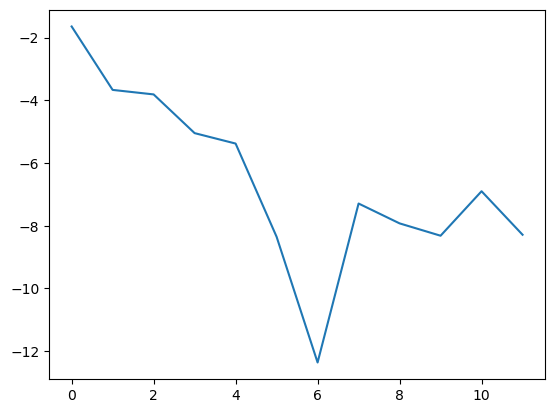

In [432]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2022].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# EUR_USD_H1 : off-years = 2014, 2016, 2021
# EUR_JPY_H1 : off-years = 2016
# GBP_JPY_H1 : off-years = 2023
# USD_MXN_H1 : off-years = 2018, 2019, 2022
# NZD_JPY_H1 : off-years = 2014, 2015, 2019

# AUD_HKD_H1 : off-years = 2015, 2018, 2019, 2021
# EUR_GBP_H1 : off-years = 2018, 2021, 2022, 2023
# ZAR_JPY_H1 : off-years = 2014, 2015, 2017, 2019
# USD_NOK_H1 : off-years = 2014, 2015
# USD_CHF_H1 : off-years = 2014
# TRY_JPY_H1 : off-years = 2014, 2019, 2021, 2022, 2023
# AUD_USD_H1 : off-years = 2015,2016,2018, 2019, 2022

In [28]:
trades_df["PnL_label"].mean()

0.3640661938534279

# STRATEGY FIXED LOSS AND PROFIT

In [22]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 2.5
start_time = 13
end_time = 21

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_sell:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', i, entry_price, 0])
        elif condition_buy:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', i, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', i, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', i, exit_price, risk_reward]
        else:
            pass
            # stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', i, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', i, exit_price, risk_reward]    
        else:
            pass
            # stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Date', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df


,Action,Date,Price,PnL,PnL_label
0,Sell,156,0.902088,-1.0,0
1,Sell,261,0.893122,1.0,1
2,Sell,340,0.908895,-1.0,0
3,Sell,394,0.908398,1.0,1
4,Sell,422,0.919866,-1.0,0
...,...,...,...,...,...
691,Buy,64512,0.805274,-1.0,0
692,Buy,64566,0.800753,-1.0,0
693,Buy,64640,0.788896,-1.0,0
694,Sell,64754,0.797848,1.0,1


In [23]:
trades_df['PnL_label'].mean()

0.5316091954022989

<Axes: >

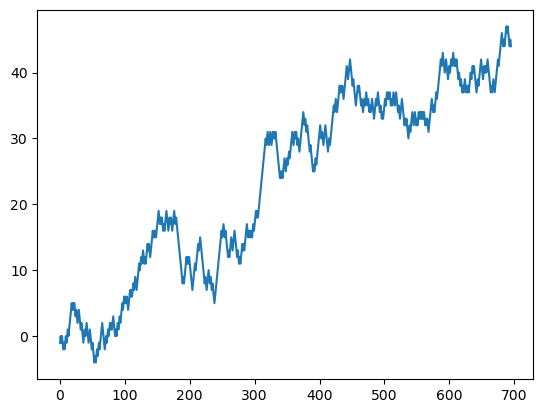

In [24]:
# using the label column find the cumulative sum
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
#plot first 100 trades
trades_df["cumulative_sum"].plot()